# Chapter 2 - Preliminaries and Bayesian Classification

Paul E. Anderson

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
home = str(Path.home()) # all other paths are relative to this path. change to something else if this is not the case on your system

## Fruit Classification with Naive Bayes Classifier

Consider a pattern recognition problem where we want to sort fruit on an assembly line. We want all the apples to be sorted with all the apples, all the oranges with the oranges, etc. We have a variety of sensor data at our displosal such as mass and width of the fruit. **How do we accomplish this and what knowledge can we extract?**

One of the first goals of any KDD or data science problem is to perform an exploratory data analysis (EDA). We will do this now. This notebook is set up for you to follow along and type as I type. 

### Reading in the data

**Stop and think: How do you display the first 5 lines of the dataframe?**

In [10]:
import pandas as pd
import numpy as np

fruits = pd.read_csv(f'{home}/csc-466-student/data/fruit_data_with_colours.csv')
# YOUR SOLUTION HERE

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


**Stop and think: Can you extract the column names?**

0      fruit_label
1       fruit_name
2    fruit_subtype
3             mass
4            width
5           height
6      color_score
dtype: object

**Terminology note:** I will often in this course refer to most of these columns as "features". This is standard terminology in KDD/ML/AI.

**Stop and think: How many examples of fruit do we have?**

59

**Stop and think: What are you unique fruit names in our dataset?**

array(['apple', 'mandarin', 'orange', 'lemon'], dtype=object)

**Stop and think: What are you unique fruit names in our dataset (take 2)?**

array(['apple', 'mandarin', 'orange', 'lemon'], dtype=object)

**Stop and think: Write some code to count the number of each type of fruit**

apple       19
orange      19
lemon       16
mandarin     5
Name: fruit_name, dtype: int64

**Stop and think: Is there an easy way to plot this with Pandas?**

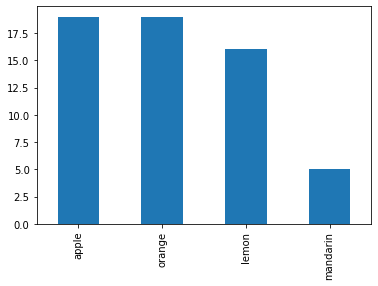

### Scope of this course

While this course could be taught without leveraging Pandas and NumPy and other packages, it is important to be ready day one and this means learning about common technologies. In other words, we will learn a bit about things such as matplotlib and altair. 

**Stop and think: Without any other information, how likely is it that a piece of fruit is a mandarin?** 

${\it Prob}({\it fruit\_name}={\it mandarin}) = ?$ 

Note: when it is convienent and non-ambiguous, we will use shorthands such as ${\it Prob}({\it fruit\_name}={\it mandarin}) = P(mandarin)$

#### What is your answer?

What if you know a little bit about the fruit? Let's say you know it has a width of 8.4. What is the probility it is a mandarin now? 

$P({\it mandarin}|width=7.4)$? 

Consider the following code:

In [23]:
sum(fruits.width == 8.4)

1

So ... is it 1/59?

We need to break down $P({\it mandarin}|width=8.4)$. 

What does the vertical bar mean?

This is a conditional probability. What we specify after the vertical bar restricts what we consider when calculating the probability. So in this example, we restrict the world to fruits of width of 8.4. 

How many fruits are there in the dataset with width=8.4?

1 ...

1 is a lonely number in statistics for sure. How can we get an idea of anything when we have just 1 of something?

We have two approaches we can now take:

1. Parametric
    1. Assume each of the features follow a parametric distribution (e.g., Gaussian, uniform)
    2. Estimate the parameters of the distribution ($\mu$,$\sigma$)
2. Non-parametric
    1. Histogram sampling
    2. Bin width is critical
    3. Smoothing can help

Back to our fruit with a width of 8.4. Let's take a look at the distribution of that features. 

**Stop and think: Can you guess how to make a histogram with matplotlib and pandas?**

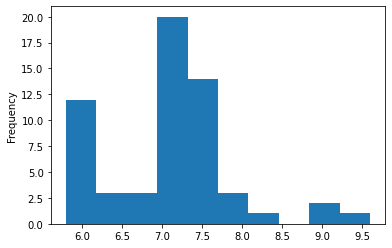

You can look at the documentation of a function in here using:

```python
fruits.width.plot.hist?
```

Give it a try :)

Does 10 look like an appropriate bin width for the width column?

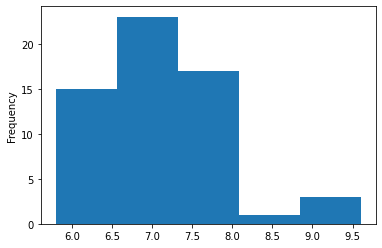

Is that better? One the biggest problems we are facing down at the moment is that in this graph there are all kinds of different fruits. They *probably* all have different distributions with different means. So even if we kept going, this approach doesn't match our intuition of a good solution.

What can we do? Our hero arrives...

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif">

https://en.wikipedia.org/wiki/Thomas_Bayes

How is he our hero you might ask? Well. Let's go back to our fruit example. Let's look at the distribution of width for each type of fruit separately.

I'm going to use another one of my favorite packages (altair). Don't worry. This is a very open book class. Memorizing APIs is not our goal.

In [26]:
import altair as alt

alt.Chart(fruits).mark_bar().encode(
    alt.X("width:Q", bin=True),
    y='count()',
    row='fruit_name:N'
)

alt.Chart(...)

That looks like it makes a bit more sense! Oranges are bigger than mandarins! OK. So what in the world do we do with this information? 

I am not going to get into smoothing right at the moment, so for the sake of this example, let's say we have a piece of fruit with a width of 7.2. Remember our purpose here. We want a fruit detector! So if this is an unknown fruit and it has a width of 7.2, then how likely is this a orange or one of the other types?

And now our hero can emerge!

Bayes rule tells us that:

$Pr(A|B)Pr(B) = Pr(B|A)Pr(A)$

OR

$\Pr(A|B)=\frac{\Pr(B|A)\Pr(A)}{\Pr(B|A)\Pr(A)+\Pr(B|\neg A)\Pr(\neg A)}$

That's a pretty cool super power... What did it even do for us?

It allowed us to **invert** the question we want to answer!!!

We want to know what the probability of a piece of fruit with width 7.2 being a mandarin, but we can calculate the inverse of that. Specifically, we can easily calculate the probability of measuring a width of 7.2 GIVEN it is a orange

$Pr(width=7.2|orange)$

Pandas can save us!

In [52]:
width_binned,width_bins = pd.cut(fruits.width.loc[fruits.fruit_name=='orange'],5,retbins=True)
width_bins

array([6.6971, 7.28  , 7.86  , 8.44  , 9.02  , 9.6   ])

In [53]:
width_binned_counts = width_binned.value_counts()
width_binned_counts

(6.697, 7.28]    10
(7.28, 7.86]      6
(9.02, 9.6]       2
(8.44, 9.02]      1
(7.86, 8.44]      0
Name: width, dtype: int64

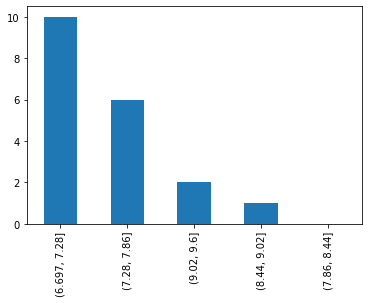

In [54]:
width_binned.value_counts().plot.bar();

How do save ourselves from counting this up ourselves for a width of 7.2?

In [55]:
binned_value = pd.cut([7.2],width_bins)[0]
binned_value

Interval(6.697, 7.28, closed='right')

In [56]:
width_binned_counts.loc[binned_value]

10

**Stop and think: What is the probability of a width of 7.2 given that the fruit is an orange?**

0.5263157894736842

How does this help us get our final answer? Bayes tells us how to invert this quantity to get what we want.

$\Pr(A|B)=\frac{\Pr(B|A)\Pr(A)}{\Pr(B|A)\Pr(A)+\Pr(B|\neg A)\Pr(\neg A)}$

I'm dropping the names here for clarity

$\Pr(orange|7.2)=\frac{\Pr(7.2|orange)\Pr(orange)}{\Pr(7.2|orange)\Pr(orange)+\Pr(7.2|\neg orange)\Pr(\neg orange)}$

We can do a lot of this now! 

**Stop and think: Fill in everything except $\Pr(7.2|\neg orange)\Pr(\neg orange)$**

#### Your solution here

So all we need to tackle now is the unknown... 

We need to figure out how to do not an orange...

What if we just did a long OR with all the fruits other than an orange... That would do it! In other words...

**Stop and think: Can you write up a loop to calculate the value specified by unknown above?** You can assume all of the same parameters that have led us to this point.

In [60]:
binned_value

nan

In [2]:
# SET likelihood to {}
# SET prior to {}
# FOR each unique fruit in fruits['fruit_name']
#    CALCULATE the bin widths for fruit using a total of 5 bins
#    CALCULATE the number of fruits of type fruit with width equal to 7.2 (using the bins you just created)
#    IF there are not any fruits with that width, set the likelihood equal to 0
#    OTHERWISE set the likelihood of that fruit equal to the fraction of total fruits in this bin
#    CALCULATE the prior probability of fruit
likelihood['orange']*prior['orange']/(likelihood['orange']*prior['orange'] + 
                                      likelihood['apple']*prior['apple'] +
                                      likelihood['lemon']*prior['lemon'] +
                                      likelihood['mandarin']*prior['mandarin'])

NameError: name 'fruits' is not defined

What is the probability that this is an apple?

In [68]:
likelihood['apple']*prior['apple']/(likelihood['orange']*prior['orange'] + 
                                      likelihood['apple']*prior['apple'] +
                                      likelihood['lemon']*prior['lemon'] +
                                      likelihood['mandarin']*prior['mandarin'])

0.19999999999999996

We just have to change the numerator! 

### What happens when we have more than just a width?

Remember we have: mass, width, height, and color_score.

We could easily handle any of these individually if we wrote our code above right, but how do we combine them?

For example:

$Pr(orange|width=7.2,height=6.5)$

Since height and width are not independent, we would not break this up in our prior statistics classes. Here comes one of our first big breaks from your prior work in statistics. We care about our results, and we often ignore what was once considered undeniable truth. This leads us to the:

### Naive Empirical Bayes Classifier

It is naive because it assumes all of our features are independent.

It is empirical because we often just bin the features like we did above.

Let's take a look at the math:

$\Pr(orange|7.2,6.5)=\frac{\Pr(7.2,6.5|orange)\Pr(orange)}{\Pr(7.2,6.5|orange)\Pr(orange)+\Pr(7.2,6.5|\neg orange)\Pr(\neg orange)}=$ 

$\Pr(orange|7.2,6.5)=\frac{\Pr(7.2|orange)\Pr(6.5|orange)\Pr(orange)}{\Pr(7.2|orange)\Pr(6.5|orange)\Pr(orange)+\Pr(7.2|\neg orange)\Pr(6.5|\neg orange)\Pr(\neg orange)}$

This we can solve! The coding of this is left up to a lab.

For a seque into the preliminaries of KDD, how do you know how well this fruit detector will work?

## KDD Preliminaries

https://docs.google.com/presentation/d/1hMB1Y9vQzT27LGfJpjMFWOZsXna23hClXtqQo6SeMQI/edit?usp=sharing

For a by-hand example of naive Bayes classifier and for additional reading for this chapter, please see Chapter 2 from Marsland.

## From Machine Learning back to KDD

Computing feature importance is one of the most common methods of extracting knowledge from a machine learning model. One of the most straightforward ways of doing so is with permutation feature importance. A discussion of this can be found at: https://christophm.github.io/interpretable-ml-book/feature-importance.html

> In the end, you need to decide whether you want to know how much the model relies on each feature for making predictions (-> training data) or how much the feature contributes to the performance of the model on unseen data (-> test data)

https://christophm.github.io/interpretable-ml-book/feature-importance.html